In [1]:
import SR_lib as sr 
from gen_time_ser_data import *
from analysis_data import *

In [2]:
import os
import pandas as pd
from scipy.interpolate import interp1d
import re

# DEV IISC vs DEV IITPKD - table 

In [3]:
def find_alpha_beta(Vc, Pr, tf):
    Ec= Vc/tf
    alpha = -3*np.sqrt(3)*Ec/4/Pr
    beta = 3*np.sqrt(3)*Ec/8/(Pr**3)
    print(f"VC = {Vc} V")
    print(f"Ec = {Ec*1e-5:.2e} kV/cm")
    print(f"Pr = {Pr*10} uC/cm^2")
    print(f"Landau coeff, alpha = {alpha:.2e} mF^-1, beta = {beta:.2e} m^5F^-1C^-1")
    return alpha, beta

def sd2Dext_delF(sd, rho, bw, tf, delF):
    Dext_delF = (sd**2)/(2*rho*bw*tf**2*delF)
    return Dext_delF

def Dext_delF2sd(Dext_delF, rho, bw, tf, delF):
    sd = np.sqrt(Dext_delF*2*rho*bw*tf**2*delF)
    return sd

In [4]:
# Sample IISC
Vc = 2.1
Pr = 0.17
tf = 255e-9
rho = 1367
bw = 1e4
tf = 255e-9
alpha , beta = find_alpha_beta(Vc, Pr, tf)
delF = sr.del_U(0, alpha, beta, tf)[0]
print(f"barrier height = {delF:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 10
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 2.1 V
Ec = 8.24e+01 kV/cm
Pr = 1.7000000000000002 uC/cm^2
Landau coeff, alpha = -6.29e+07 mF^-1, beta = 1.09e+09 m^5F^-1C^-1
barrier height = 9.09e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 15.464689576323975
 Dext_delF to sd convertion: Dext_DelF = 10 -> sd = 4.02067899377736


In [5]:
# Sample IITPKD
Vc = 1.7
Pr = 0.161
tf = 255e-9
rho = 390
bw = 3e4
tf = 255e-9
alpha , beta = find_alpha_beta(Vc, Pr, tf)
print(f"barrier height = {sr.del_U(0, alpha, beta, tf)[0]:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 10
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 1.7 V
Ec = 6.67e+01 kV/cm
Pr = 1.61 uC/cm^2
Landau coeff, alpha = -5.38e+07 mF^-1, beta = 1.04e+09 m^5F^-1C^-1
barrier height = 6.97e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 18.068573205841776
 Dext_delF to sd convertion: Dext_DelF = 10 -> sd = 3.7197013686829914


# Time Series plot for 3 Different Dext/DelF values

### Cross Cov, Power and SNR plots for Dev IISC, Dev IITPKD

### (simulation and simulation with Experiement)

#### DEV-IISc


In [6]:
# Sample IISC
Vc = 2.1
Pr = 0.17
tf = 255e-9
rho = 1367
bw = 1e4
tf = 255e-9
Af = 1000e-12
alpha , beta = find_alpha_beta(Vc, Pr, tf)
delF = sr.del_U(0, alpha, beta, tf)[0]
print(f"barrier height = {delF:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 10
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 2.1 V
Ec = 8.24e+01 kV/cm
Pr = 1.7000000000000002 uC/cm^2
Landau coeff, alpha = -6.29e+07 mF^-1, beta = 1.09e+09 m^5F^-1C^-1
barrier height = 9.09e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 15.464689576323975
 Dext_delF to sd convertion: Dext_DelF = 10 -> sd = 4.02067899377736


In [7]:
#function to load data
def load_data(file_path, start_i, end_i):
    PV_data = pd.read_excel(file_path)
    P = np.array(PV_data.iloc[start_i:end_i, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
    V = np.array(PV_data.iloc[start_i:end_i, 2].to_list())
    t = np.array(PV_data.iloc[start_i:end_i, 1].to_list())*1e-3
    return P,V,t

def SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70):
    Vc = params.get('Vc')
    Pr = params.get('Pr')
    alpha = params.get('alpha')
    beta = params.get('beta')
    rho = params.get('rho')
    tf = params.get('tf')
    Af = params.get('Af')
    T = params.get('T')
    Asig = params.get('A')
    fsig = params.get('f')
    sd = params.get('sd')
    ts = params.get('ts')
    n = params.get('n')
    ens = params.get('ens')
    dsf = params.get('dsf')  # Downsampling factor
    bw = params.get('bw') 

    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[0]:.2f}_ens{0}.txt')
    E0 = Edrive
    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{Vc*1.5}V_sd{sd[0]:.2f}_ens{0}.txt')
    Pswitch = P
    for i in range(len(sd)):
        Cov_ens = 0
        psd_ens = 0
        psd_noise_ens = 0
        for e in range(ens):
            t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[i]:.2f}_ens{e}.txt')
            Cov_ens += np.cov(P,Pswitch)[1,0]    
            freq, psd = sr.signal_psd(P, f, 1/(dsf*ts), delw)
            freq, psd_noise = sr.signal_psd((Edrive - E0)*tf, f, 1/(dsf*ts), delw)
            psd_ens += psd
            psd_noise_ens += psd_noise

        P_ens, NF_ens, SNR_ens = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)
        # P_ens, NF_ens, SNR_ens, _, _ = sr.power_snr_noisefloor(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)

        ffro = int(2*len(freq)/ (1/(dsf*ts))*(f - delw_noise)) + 1
        fto = int(2*len(freq)/ (1/(dsf*ts))*(f + delw_noise)) + 1
        
        PSD.append(psd_ens/ens)
        PSR.append(P_ens)
        NF.append(NF_ens)
        SNR.append(SNR_ens)
        COV.append(Cov_ens/ens)
        sd_crt.append(sr.sd_correction(Edrive*tf,E0*tf))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw_crt, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

def SR_matrics_exp(sd, V, P, V0, Pswitch, bw, f, alpha, beta, rho, tf, Af, delw=5, delw_noise = 70):
    # calculating the matrics
    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    for i in range(len(sd)):
        Cov = np.cov(P[i],Pswitch)[1,0]    
        freq, psd = sr.signal_psd(P[i], f, bw, delw)
        freq, psd_noise = sr.signal_psd((V[i] - V0), f, bw, delw)
        Pwr, Nf, Snr = sr.power_snr_noisefloor_iisc(freq, psd , f,  bw, delw, delw_noise)
    
        PSD.append(psd)
        PSR.append(Pwr)
        NF.append(Nf)
        SNR.append(Snr)
        COV.append(Cov)
        sd_crt.append(sr.sd_correction(V[i],V0))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV
    

In [17]:
## Read the Parse file
params_path = 'sim_3\\parameters.txt'  # Parse input file
params = sr.read_simulation_parameters(params_path)
## Create the simulation directory
id = params.get('id')
output_dir = f'sim_{id}'
os.makedirs(output_dir, exist_ok=True)
raw_data_file = os.path.join(output_dir, "raw_data")

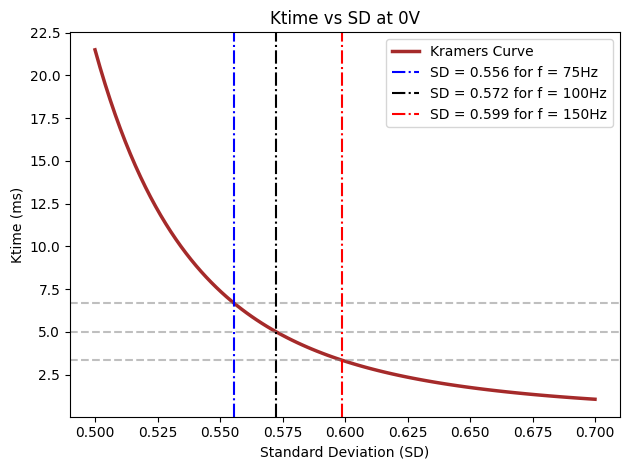

In [18]:
sd_range = np.linspace(0.5,0.7,100)
rho = 1300
Ktime = sr.calculate_kramer_curve(sd_range, 0, alpha, beta, rho, bw, tf, Af)

# Plot the curve
plt.plot(sd_range, Ktime*1e3, linewidth = 2.5, color = "brown", label='Kramers Curve')
c = ["blue", "black", "red"]
# Target Ktime in ms
fsig = [75, 100, 150]
sd_opt_f = []
for i, f in enumerate(fsig):
    target_time = 1/(2*f)
    interp_fn = interp1d(Ktime, sd_range, bounds_error=False, fill_value="extrapolate")
    sd_opt = interp_fn(target_time)
    sd_opt_f.append(sd_opt)
    Dext_delF_opt = sr.Dext_delF(sd_opt, bw, alpha, beta, rho, tf, Af)[0]
    # Draw horizontal line at target time
    plt.axhline(y=target_time*1e3, color='gray', linestyle='--', alpha = 0.5)
    # Draw vertical line at corresponding SD
    plt.axvline(x=sd_opt, color=c[i], linestyle='-.', label=f'SD = {sd_opt:.3f} for f = {f}Hz')
# Axis labels and title
plt.xlabel('Standard Deviation (SD)')
plt.ylabel('Ktime (ms)')
plt.title('Ktime vs SD at 0V')
plt.legend()
# plt.grid(True)
plt.tight_layout()

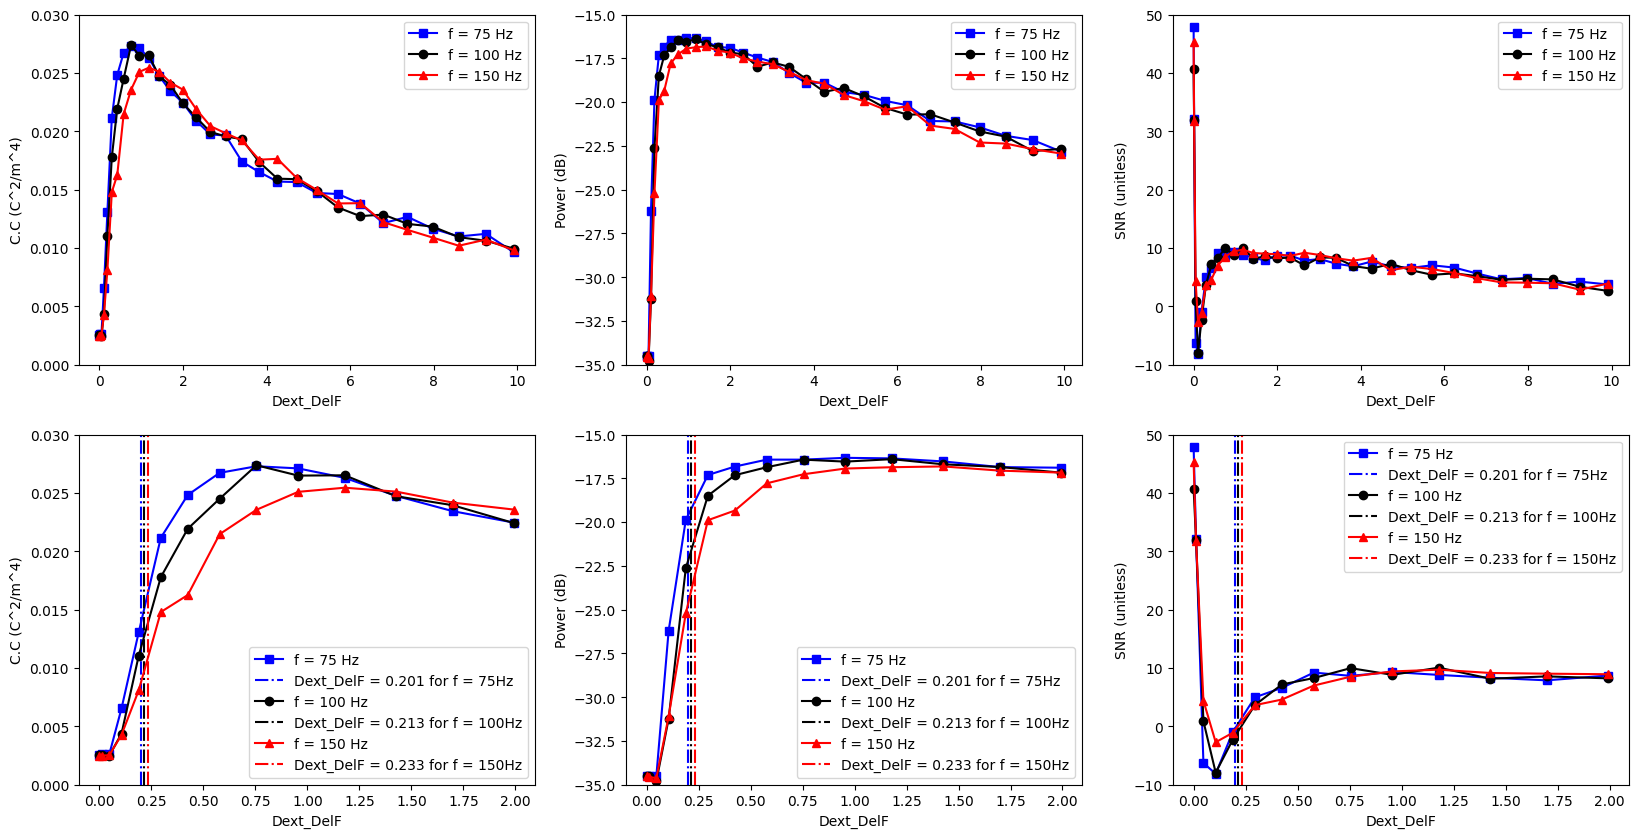

In [19]:
Asig = params.get('A')
fsig = params.get('f')
clr = ["blue", "black", "red"]
styl = ["-s", "-o", "-^"]
Dext_DelF_opt = sd2Dext_delF(np.array(sd_opt_f), rho, bw, tf, delF)
plt.figure(figsize=(20,10))
for i in range(len(fsig)):
    f = fsig[i]
    A = Asig[0]
    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)
    # full Range
    plt.subplot(2,3,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.ylim([0, 0.03]); plt.legend()
    plt.subplot(2,3,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.ylim([-35, -15]);  plt.legend()
    plt.subplot(2,3,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.ylim([-10, 50]);  plt.legend()

    # Zoomed version
    to = 14
    plt.subplot(2,3,4); plt.plot(Dext_delF[0:to], COV[0:to],styl[i], c = clr[i], label = f"f = {f} Hz")
    plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.ylim([0, 0.03]); plt.legend()

    plt.subplot(2,3,5); plt.plot(Dext_delF[0:to], 10*np.log10(PSR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.ylim([-35, -15]);  plt.legend()

    plt.subplot(2,3,6); plt.plot(Dext_delF[0:to], 10*np.log10(SNR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.ylim([-10, 50]);  plt.legend()

In [11]:
IISc_data_path = "C:\\Drive\\FE_SR\\IITPKD_data_analysis\\sim_for_final_figs\\IISc_data\\"

#load all the data's 75 Hz, 100Hz, 150 Hz
sd = np.linspace(0.0,5.1,35)
P_data = []
V_data = []
t_data = []

start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
f_data = [75, 100, 150]

#index after the poling pulse
fro = int(bw + 48)

for j in range(0,3):
    P_f = []
    V_f = []
    t_f = []
    for i in range(0,len(sd)):
        file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd[i]:.2f}.xls'    
        Ptemp, Vtemp, ttemp = load_data(file_path, start_i[j], end_i[j])    
        P_f.append(np.array(Ptemp[fro:]))
        V_f.append(np.array(Vtemp[fro:]))
        t_f.append(np.array(ttemp[fro:]))
    P_data.append(P_f)
    V_data.append(V_f)
    t_data.append(t_f)

# reading Hyst data (for the super threshold signal)
PV_data = pd.read_excel(IISc_data_path + "hyst_1000hz.xlsx")
Pswitch = np.array(PV_data.iloc[46:43+2002, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
tswitch = np.array(PV_data.iloc[46:43+2002, 1].to_list())*1e-3

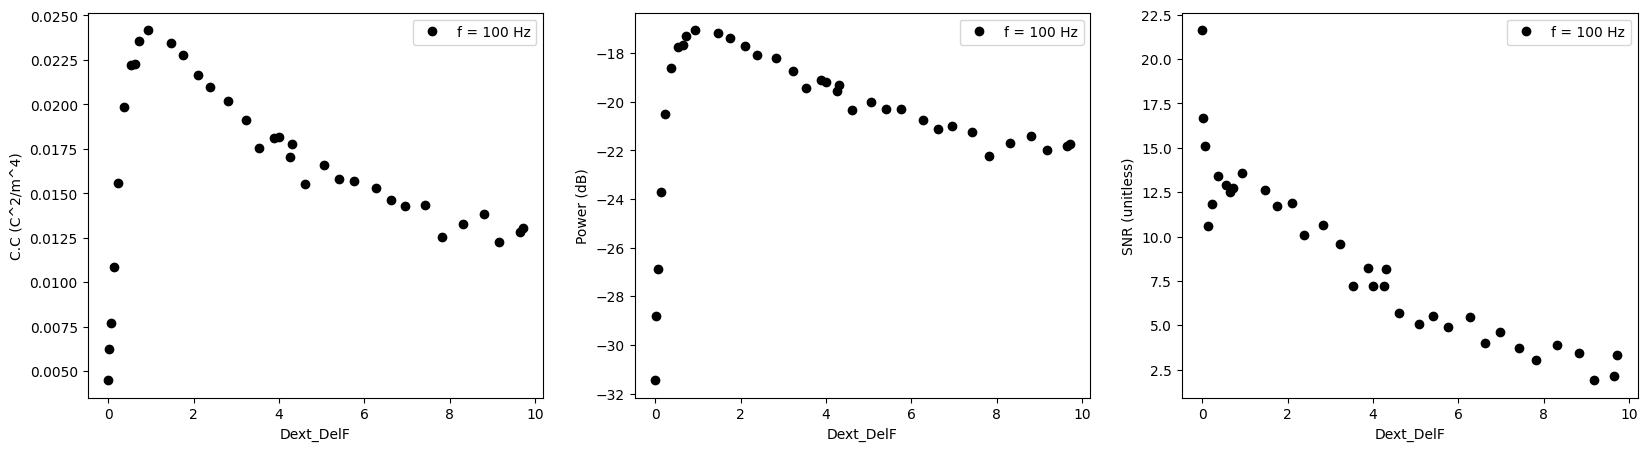

In [12]:
styl = ["s", "o", "^"]
plt.figure(figsize=(20,5))
for i in [1]:#range(len(f_data)):
    V = V_data[i]
    V0 = V_data[i][0]
    P = P_data[i]
    
    # code to make the Pswitch signal
    P_switch = list(Pswitch*2/3)*75
    time_switch = np.linspace(t_data[i][0][0], t_data[i][0][-1], len(P_switch))
    time_switch_gen = t_data[i][0]
    interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
    P_switch_gen = interp_func(time_switch_gen)

    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics_exp(sd, V, P, V0, P_switch_gen, bw, f_data[i], alpha, beta, rho, tf, Af, delw=4, delw_noise = 70)
    plt.subplot(1,3,1); plt.plot(Dext_delF_crt, COV, styl[i], c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
    plt.subplot(1,3,2); plt.plot(Dext_delF_crt, 10*np.log10(PSR), styl[i],  c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()
    plt.subplot(1,3,3); plt.plot(Dext_delF_crt, 10*np.log10(SNR), styl[i],  c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.legend()


### (Simulation Vs Experiement)

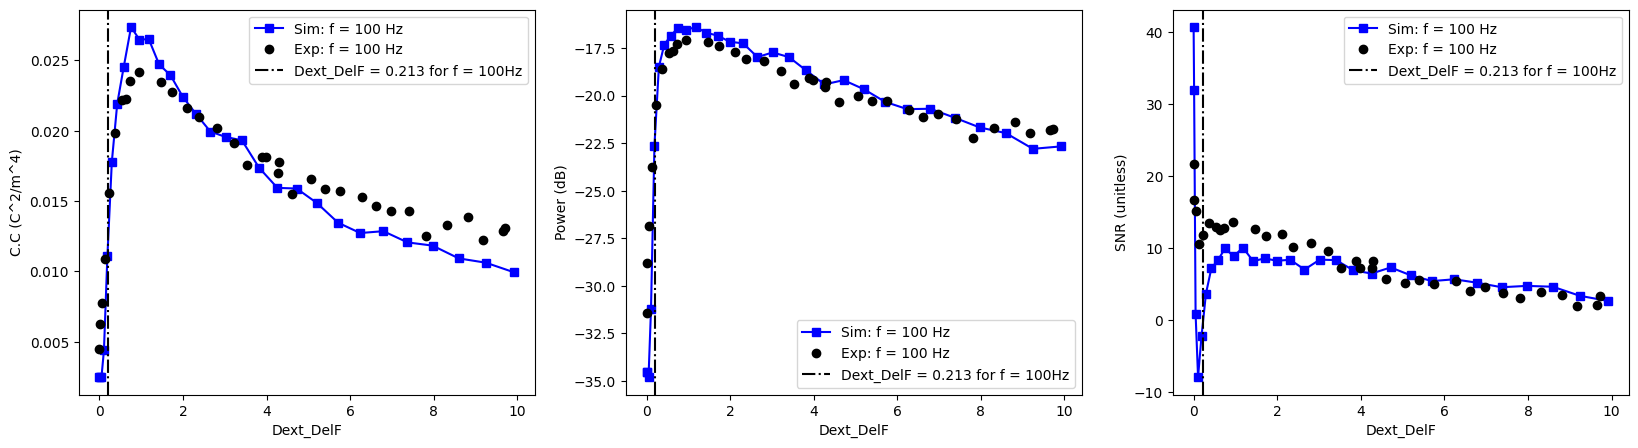

In [20]:
Asig = params.get('A')
fsig = params.get('f')
clr = ["blue", "black", "red"]
styl = ["-s", "-o", "-^"]
plt.figure(figsize=(20,5))
f = fsig[1] # 100 Hz
A = Asig[0]
i = 0
sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)
plt.subplot(1,3,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
plt.subplot(1,3,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()
plt.subplot(1,3,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)");  plt.legend()

i = 1 # 100 hz
V = V_data[i]
V0 = V_data[i][0]
P = P_data[i]

# code to make the Pswitch signal
P_switch = list(Pswitch*2/3)*75
time_switch = np.linspace(t_data[i][0][0], t_data[i][0][-1], len(P_switch))
time_switch_gen = t_data[i][0]
interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
P_switch_gen = interp_func(time_switch_gen)

styl = ["s", "o", "^"]

sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics_exp(sd, V, P, V0, P_switch_gen, bw, f_data[i], alpha, beta, rho, tf, Af, delw=4, delw_noise = 70)
plt.subplot(1,3,1); plt.plot(Dext_delF_crt, COV, styl[i], c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()

plt.subplot(1,3,2); plt.plot(Dext_delF_crt, 10*np.log10(PSR), styl[i],  c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()

plt.subplot(1,3,3); plt.plot(Dext_delF_crt, 10*np.log10(SNR), styl[i],  c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.legend()


(0.0, 3.0)

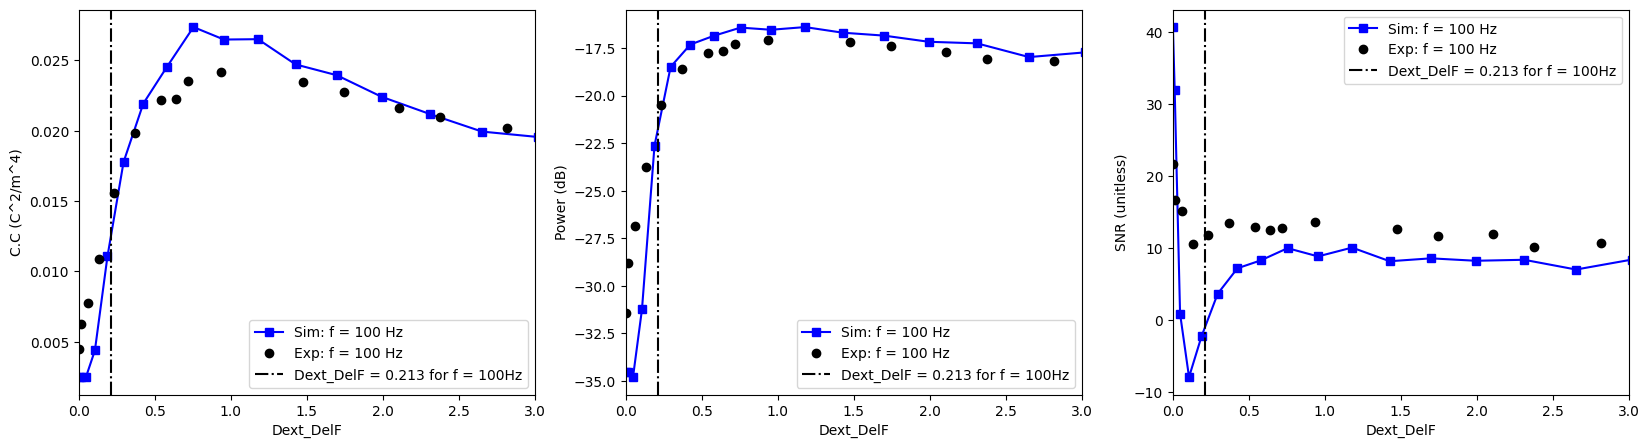

In [21]:
# Zoomed version
to = 18
Asig = params.get('A')
fsig = params.get('f')
clr = ["blue", "black", "red"]
styl = ["-s", "-o", "-^"]
plt.figure(figsize=(20,5))
f = fsig[1] # 100 Hz
A = Asig[0]
i = 0
sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)
plt.subplot(1,3,1); plt.plot(Dext_delF[0:to], COV[0:to],styl[i], c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
plt.subplot(1,3,2); plt.plot(Dext_delF[0:to], 10*np.log10(PSR[0:to]),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()
plt.subplot(1,3,3); plt.plot(Dext_delF[0:to], 10*np.log10(SNR[0:to]),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)");  plt.legend()

i = 1 # 100 hz
V = V_data[i]
V0 = V_data[i][0]
P = P_data[i]

# code to make the Pswitch signal
P_switch = list(Pswitch*2/3)*75
time_switch = np.linspace(t_data[i][0][0], t_data[i][0][-1], len(P_switch))
time_switch_gen = t_data[i][0]
interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
P_switch_gen = interp_func(time_switch_gen)

styl = ["s", "o", "^"]

sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics_exp(sd, V, P, V0, P_switch_gen, bw, f_data[i], alpha, beta, rho, tf, Af, delw=4, delw_noise = 70)
plt.subplot(1,3,1); plt.plot(Dext_delF_crt[0:to], COV[0:to], styl[i], c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend(); plt.xlim([0,3])

plt.subplot(1,3,2); plt.plot(Dext_delF_crt[0:to], 10*np.log10(PSR[0:to]), styl[i],  c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend(); plt.xlim([0,3])

plt.subplot(1,3,3); plt.plot(Dext_delF_crt[0:to], 10*np.log10(SNR[0:to]), styl[i],  c = clr[i], label = f"Exp: f = {f_data[i]} Hz")
plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.legend(); plt.xlim([0,3])


#### DEV - IITPKD

In [22]:
def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_section = False
    column_data = []
    for line in lines:
        if "Data" in line:
            data_section = True
            continue
        if data_section:
            values = re.split(r'\s+', line.strip())
            if len(values) >= 8 and values[0].isdigit():  # Ensure valid data row
                column_data.append([float(v) for v in values])
    # Transpose the data to get lists for each column
    columns = list(map(list, zip(*column_data)))
    return columns

def SR_matric_exp_IITPKD(sd, ens, Pswitch, bw, f, alpha, beta, rho, tf, Af, raw_data_file, delw =5 , delw_noise = 70):
        PSD = []
        PSR = []
        NF = []
        SNR = []
        COV = []
        sd_crt = []
        bw_crt = []
        fro = 250
        tdrive, Vdrive, _ = sr.extract_tEP_data(raw_data_file + f"\\data_sd_{sd[0]}_itr{0}.txt")
        V0 =  Vdrive[fro:]
        ts = (tdrive[1] - tdrive[0])*1e-3
        for i in range(len(sd)):
            Cov_ens = 0
            psd_ens = 0
            psd_noise_ens = 0
            for e in range(ens):
                if(i == 0): # this is an adjustment to account for only 1 ensemble for the 0 sd
                    e = 0
                if((i == 13) & (e == 9)):
                    e = 8  # this is an adjustment 
                tdrive, Vdrive, P = sr.extract_tEP_data(raw_data_file + f"\\data_sd_{sd[i]}_itr{e}.txt")
                Vdrive = Vdrive[fro:]
                P = P[fro:]
                Cov_ens += np.cov(P,Pswitch)[1,0]    
                freq, psd = sr.signal_psd(P, f, 1/ts, delw)
                freq, psd_noise = sr.signal_psd(Vdrive - V0, f, 1/ts, delw)
                psd_ens += psd
                psd_noise_ens += psd_noise

            Pwr, Nf, Snr = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens, f,  1/ts, delw, delw_noise)
            PSD.append(psd_ens/ens)
            PSR.append(Pwr)
            NF.append(Nf)
            SNR.append(Snr)
            COV.append(Cov_ens/ens)
            sd_crt.append(sr.sd_correction(Vdrive,V0))
            bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

        sd_crt = np.array(sd_crt)
        bw_crt = np.array(bw_crt)
        Dext_delF = sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af)
        Dext_delF_crt = sr.Dext_delF(sd_crt, bw, alpha, beta, rho, tf, Af)
        return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

In [23]:
# Sample IITPKD
Vc = 1.7
Pr = 0.161
tf = 255e-9
rho = 390
bw = 10e4
tf = 255e-9
alpha , beta = find_alpha_beta(Vc, Pr, tf)
print(f"barrier height = {sr.del_U(0, alpha, beta, tf)[0]:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 4
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 1.7 V
Ec = 6.67e+01 kV/cm
Pr = 1.61 uC/cm^2
Landau coeff, alpha = -5.38e+07 mF^-1, beta = 1.04e+09 m^5F^-1C^-1
barrier height = 6.97e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 5.420571961752531
 Dext_delF to sd convertion: Dext_DelF = 4 -> sd = 4.29514117302829


In [24]:
## Read the Parse file
params_path = 'sim_5\\parameters.txt'  # Parse input file
params = sr.read_simulation_parameters(params_path)
## Create the simulation directory
id = params.get('id')
output_dir = f'sim_{id}'
os.makedirs(output_dir, exist_ok=True)
raw_data_file = os.path.join(output_dir, "raw_data")

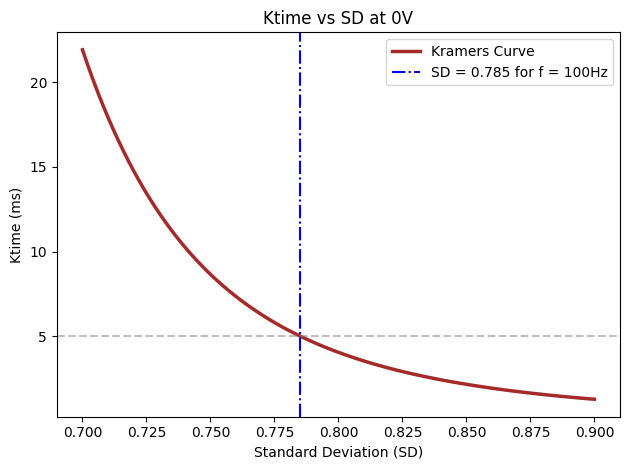

In [27]:
sd_range = np.linspace(0.7,0.9,100)
Ktime = sr.calculate_kramer_curve(sd_range, 0, alpha, beta, rho, bw, tf, Af)

# Plot the curve
plt.plot(sd_range, Ktime*1e3, linewidth = 2.5, color = "brown", label='Kramers Curve')
c = ["blue", "black", "red"]
# Target Ktime in ms
fsig = [100]
sd_opt_f = []
for i, f in enumerate(fsig):
    target_time = 1/(2*f)
    interp_fn = interp1d(Ktime, sd_range, bounds_error=False, fill_value="extrapolate")
    sd_opt = interp_fn(target_time)
    sd_opt_f.append(sd_opt)
    Dext_delF_opt = sr.Dext_delF(sd_opt, bw, alpha, beta, rho, tf, Af)[0]
    # Draw horizontal line at target time
    plt.axhline(y=target_time*1e3, color='gray', linestyle='--', alpha = 0.5)
    # Draw vertical line at corresponding SD
    plt.axvline(x=sd_opt, color=c[i], linestyle='-.', label=f'SD = {sd_opt:.3f} for f = {f}Hz')
# Axis labels and title
plt.xlabel('Standard Deviation (SD)')
plt.ylabel('Ktime (ms)')
plt.title('Ktime vs SD at 0V')
plt.legend()
# plt.grid(True)
plt.tight_layout()

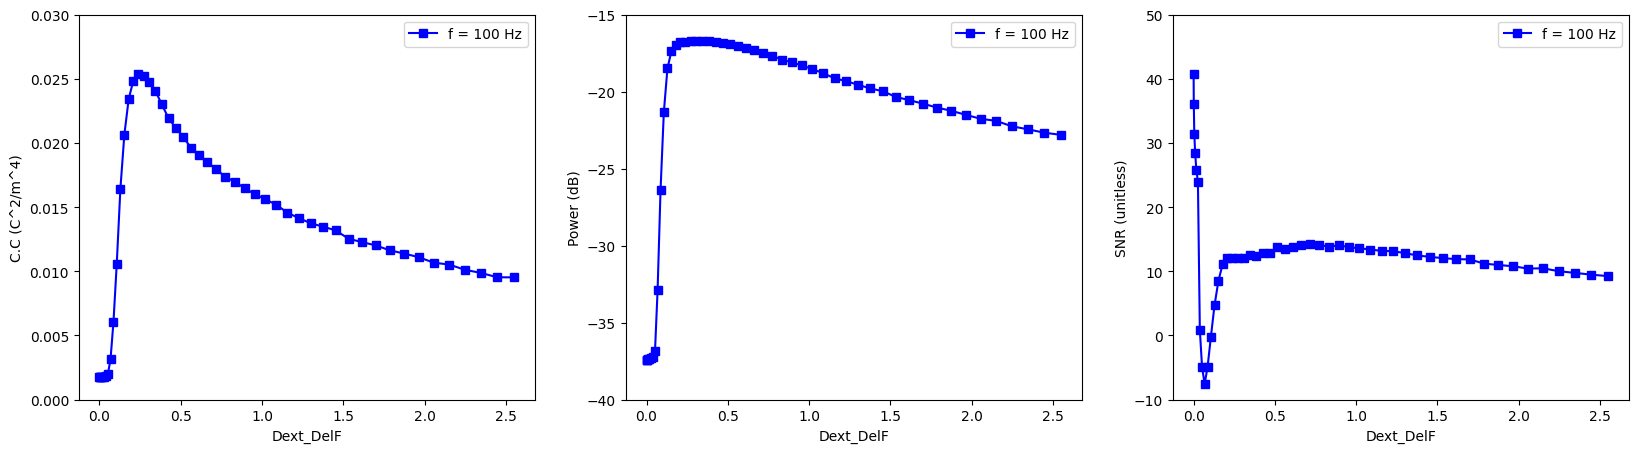

In [34]:
Asig = params.get('A')
fsig = params.get('f')
clr = ["blue"]
styl = ["-s"]
i = 0
Dext_DelF_opt = sd2Dext_delF(np.array(sd_opt_f), rho, bw, tf, delF)
plt.figure(figsize=(20,5))
for i in range(len(fsig)):
    f = fsig[i]
    A = Asig[0]
    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)
    # full Range
    plt.subplot(1,3,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.ylim([0, 0.03]); plt.legend()
    plt.subplot(1,3,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.ylim([-40, -15]);  plt.legend()
    plt.subplot(1,3,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"f = {f} Hz")
    plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.ylim([-10, 50]);  plt.legend()

    # # Zoomed version
    # to = 20
    # plt.subplot(2,3,4); plt.plot(Dext_delF[0:to], COV[0:to],styl[i], c = clr[i], label = f"f = {f} Hz")
    # plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    # plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.ylim([0, 0.03]); plt.legend()

    # plt.subplot(2,3,5); plt.plot(Dext_delF[0:to], 10*np.log10(PSR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
    # plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    # plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.ylim([-40, -15]);  plt.legend()

    # plt.subplot(2,3,6); plt.plot(Dext_delF[0:to], 10*np.log10(SNR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
    # plt.axvline(x=Dext_DelF_opt[i], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[i]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
    # plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.ylim([-10, 50]);  plt.legend()
plt.savefig("IITPKD_sample_sim.pdf")

In [43]:
Dext_DelF_opt

array([0.13361343])

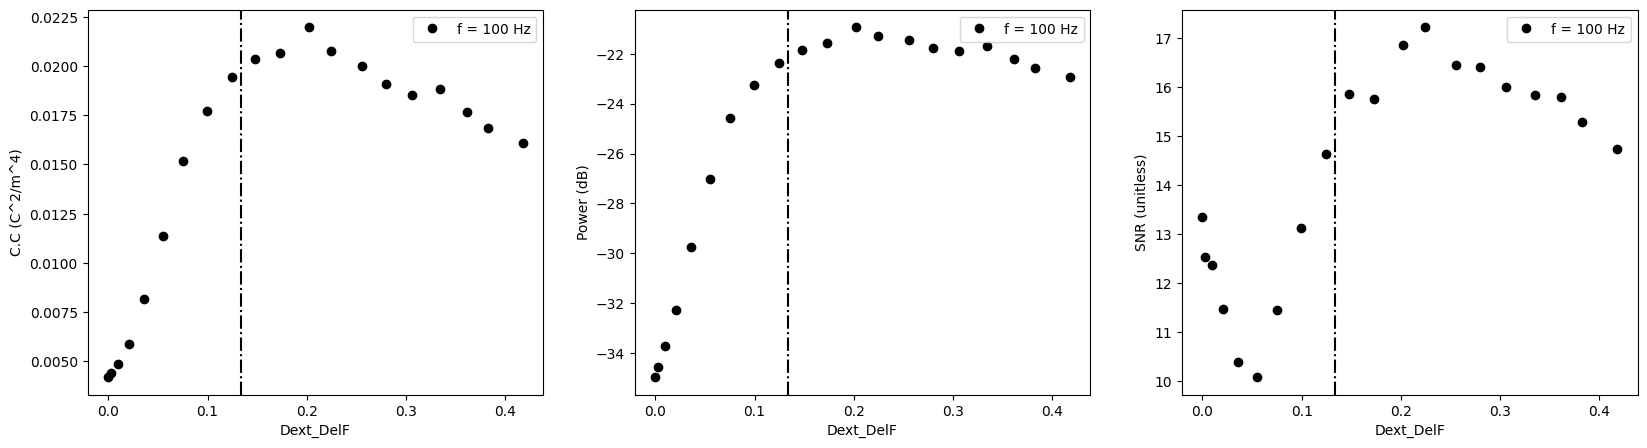

In [35]:
IITPKD_data_path = "C:\\Drive\\FE_SR\\IITPKD_data_analysis\\sim_for_final_figs\\IITPKD_data\\"
raw_data = IITPKD_data_path + "freq_100"
clr = ["black"]
styl = ["o"]
i = 0

sd = np.arange(0, 2, 0.1)
no_ens = 10
# code to make the Pswitch signal
data_columns = extract_data(IITPKD_data_path + f"Hysteresis{100}Hz.txt")
time_switch, _, P_switch, _, _, _, _ = data_columns[1:]
time_switch = np.array(time_switch)*1e-3
P_switch = np.array(P_switch)*1e-2
fro = 250
t_data, V_data, _ = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd[0]}_itr{0}.txt")
t_data = t_data[fro:]
V_data = V_data[fro:]
P_switch = list(Pswitch)*30
time_switch = np.linspace(t_data[0], t_data[-1], len(P_switch))
time_switch_gen = t_data
interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
P_switch_gen = interp_func(time_switch_gen)

sd_crt_exp, bw_crt_exp, Dext_delF_exp, Dext_delF_crt_exp, PSR_exp, NF_exp, SNR_exp, COV_exp = SR_matric_exp_IITPKD(
    sd, no_ens, P_switch_gen, bw, f, alpha, beta, rho, tf, Af, raw_data, delw =5 , delw_noise = 70)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], c = clr[i], label = f"f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD

plt.savefig("IITPKD_sample_meas.pdf")

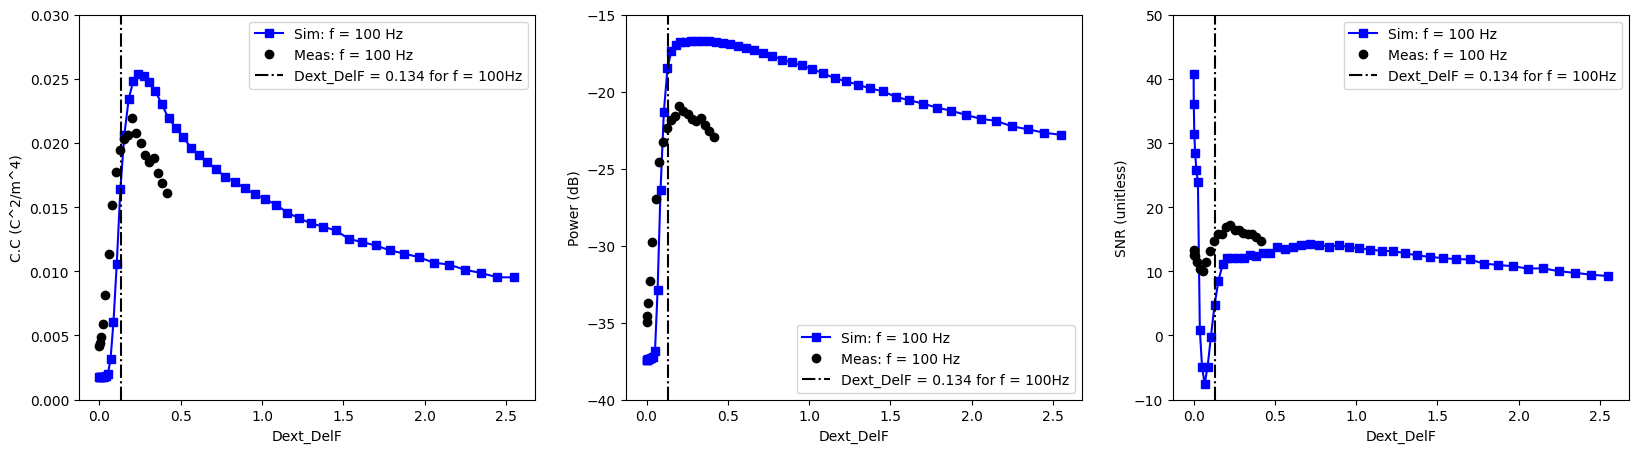

In [30]:
plt.figure(figsize=(20,5))
clr = ["blue"]
styl = ["-s"]
plt.subplot(1,3,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"Sim: f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.ylim([0, 0.03]); plt.legend()
plt.subplot(1,3,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.ylim([-40, -15]);  plt.legend()
plt.subplot(1,3,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"Sim: f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.ylim([-10, 50]);  plt.legend()
clr = ["black"]
styl = ["o"]
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], c = clr[i], label = f"Meas: f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)")
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz'); plt.legend() # Draw vertical line at corresponding SD
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i],  c = clr[i], label = f"Meas: f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)")
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz'); plt.legend() # Draw vertical line at corresponding SD
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i],  c = clr[i], label = f"Meas: f = {100} Hz"); plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)")
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz'); plt.legend() # Draw vertical line at corresponding SD

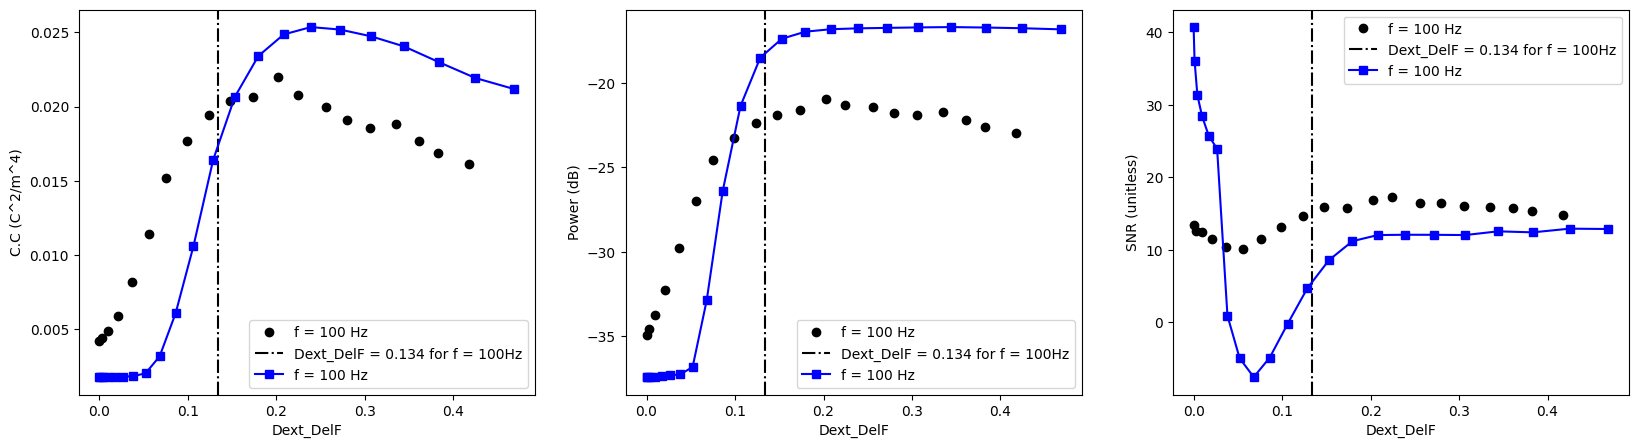

In [42]:
plt.figure(figsize=(20,5))
clr = ["black"]
styl = ["o"]
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], c = clr[i], label = f"f = {100} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i],  c = clr[i], label = f"f = {100} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f} for f = {f}Hz') # Draw vertical line at corresponding SD

clr = ["blue"]
styl = ["-s"]
to = 22
plt.subplot(1,3,1); plt.plot(Dext_delF[0:to], COV[0:to],styl[i], c = clr[i], label = f"f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("C.C (C^2/m^4)"); plt.legend()
plt.subplot(1,3,2); plt.plot(Dext_delF[0:to], 10*np.log10(PSR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("Power (dB)"); plt.legend()
plt.subplot(1,3,3); plt.plot(Dext_delF[0:to], 10*np.log10(SNR[0:to]),styl[i],  c = clr[i], label = f"f = {f} Hz")
plt.xlabel("Dext_DelF"); plt.ylabel("SNR (unitless)");plt.legend()

plt.savefig("IITPKD_sample_sim_meas.pdf")

### Time series plots

0.1838970183828627
0.7826410124474121
1.2150611303693128


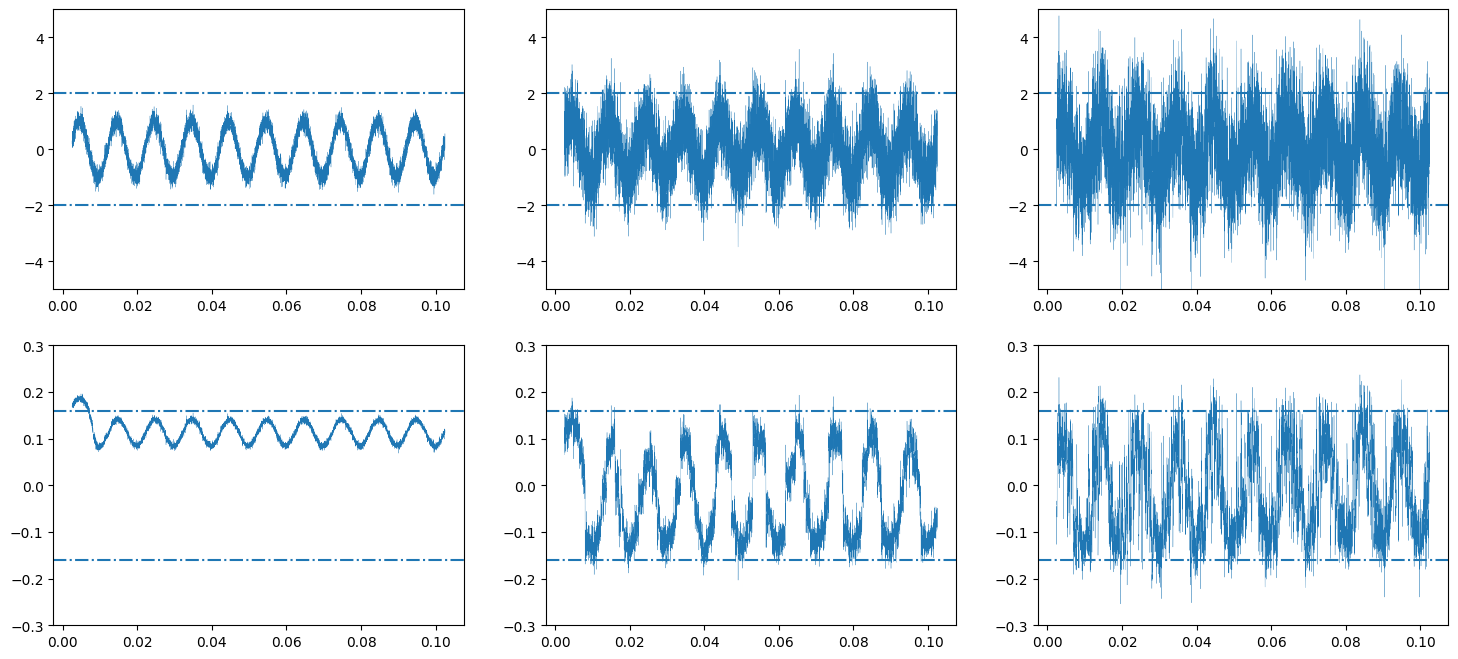

In [91]:

sd_idx = [2, 10, 19]
fro1 = 0
to1 = 10000
plt.figure(figsize=(18,8))
for e, i in enumerate(sd_idx):
    fro = 250
    print(sd_crt_exp[i])
    t_data, V_data, P_data = sr.extract_tEP_data(IITPKD_data_path + f"freq_100\\data_sd_{sd[i]}_itr{0}.txt")
    t_data = t_data[fro:]*1e-3
    V_data = V_data[fro:]
    P_data = P_data[fro:]
    plt.subplot(2,3,e+1); plt.plot(t_data[fro1:to1], V_data[fro1:to1], linewidth = 0.2); plt.ylim([-5,5])
    plt.axhline(y=2, linestyle='-.')
    plt.axhline(y=-2, linestyle='-.')
    plt.subplot(2,3,e+4); plt.plot(t_data[fro1:to1], P_data[fro1:to1], linewidth = 0.2); plt.ylim([-0.3,0.3])
    plt.axhline(y=0.16, linestyle='-.')
    plt.axhline(y=-0.16, linestyle='-.')

plt.savefig("PT_SR_exp.pdf")

0.18
0.8
1.22


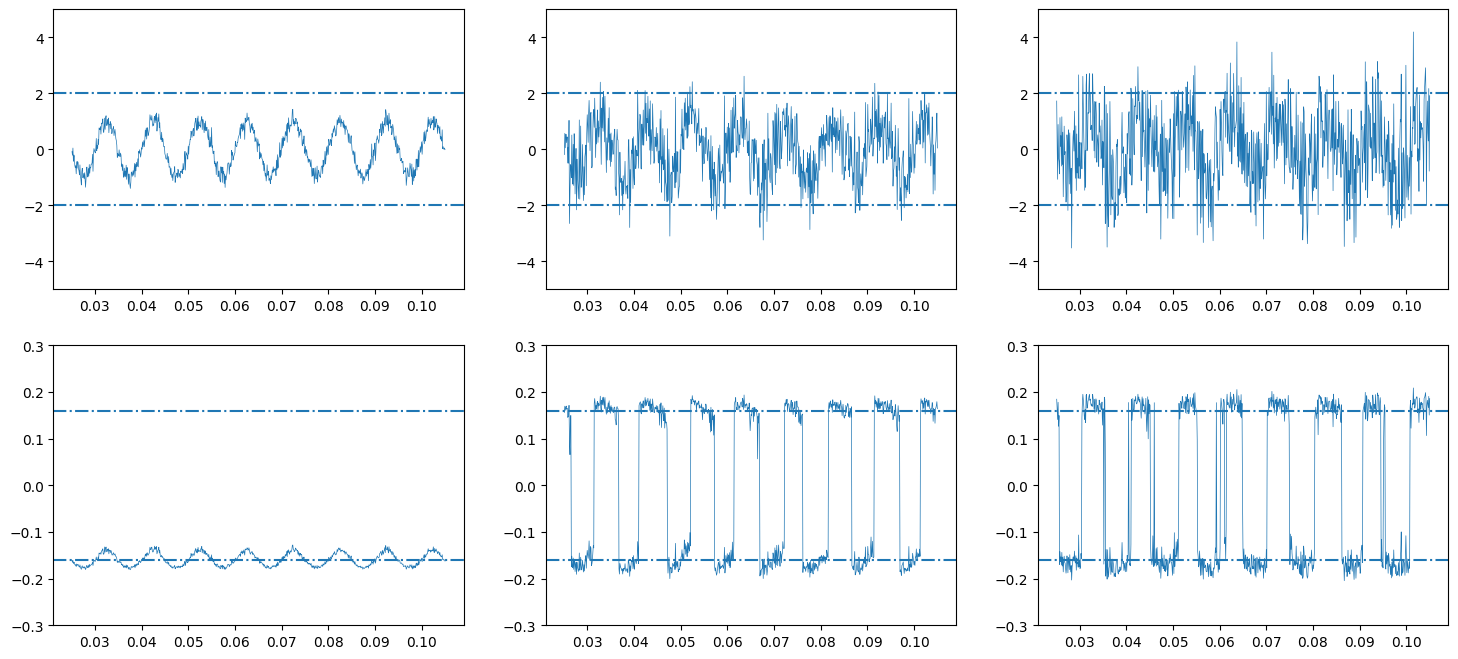

In [ ]:

sd_idx = [0.18, 0.80, 1.22]
fro1 = 0
to1 = 800
plt.figure(figsize=(18,8))
for e, i in enumerate(sd_idx):
    fro = 250
    # print(sd_crt_exp[i])
    print(i)
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{i:.2f}_ens{0}.txt')
    t_data = t_data[fro:]
    V_data = V_data[fro:]*tf
    P_data = P_data[fro:]
    plt.subplot(2,3,e+1); plt.plot(t_data[fro1:to1], V_data[fro1:to1], linewidth = 0.5); plt.ylim([-5,5])
    plt.axhline(y=2, linestyle='-.')
    plt.axhline(y=-2, linestyle='-.')
    plt.subplot(2,3,e+4); plt.plot(t_data[fro1:to1], P_data[fro1:to1], linewidth = 0.5); plt.ylim([-0.3,0.3])
    plt.axhline(y=0.16, linestyle='-.')
    plt.axhline(y=-0.16, linestyle='-.')

plt.savefig("PT_SR_sim.pdf")